# Exploration of Kernel Hearding for collecting super samples of a distribution

## The problem(s)
Deterministic methods for numerically calculating mulit-dimensional integrals $I = \int f(x)p(x)dx$ is scale poorly as the number of dimensions increase. This problem occurs frequently in calculating expectation values and marginal distributions.

Random iid sampling of $p(x)$ and evaluating the integral as $I \approx \frac{1}{N} \sum f(x_i)$ scales in a dimension agnostic way and converges to the true value as $I\approx \frac{1}{\sqrt(N)}$. 

A second problem is the need to reduce the amount of memory required estimate $p(x)$ for future use. An algorithm that can better estimate $p(x)$ would help solve both of these problems.

Improving this rate of convergence is a goal of kernel herding which seeks take advantage of the assumption that $p(x)$ is smooth and sample it in an optimal way to produce a set of 'super samples' that

## Kernel herding
A newer method, kernel herding, promises to converge on an estimate of $I$ somewhere between $\frac{1}{\sqrt(N)}$ and $\frac{1}{N}$. Kernel herding assumes that $p(x)$ is 'smooth', and then detrministically and recursively picking samples from $p(x)$. Every new sample 'knows' about the previous samples and stays away from them while still faithfully representing $p(x)$.

This algorithm finds each 'super sample' $x_{ss,i}$ by finding the point that maximizes:
$x_{ss,i} = argmax_x(\int k(x,x')p(x')dx' - \frac{1}{i}\sum k(x,x_{ss,i-1})$)
where $k(.,.)$ is a suitable kernel. For this demonstration I use $k(x,x')=e^{-norm(x-x')/\gamma^2}$ with $\gamma = 1$.

I call the first term the expectation value of the kernel expKer = $\int k(x,x')p(x')dx'$ and can be viewed as a weight drawing a point near regions of high probability density, while the second term sumKer = $\frac{1}{i}\sum k(x,x_{ss,i-1})$ acts to repel each point from all previous points.

## Implementation here
Create a low dimensional gaussian mixture model.

Sample points from $p(x)$ as an estimate.

Select an arbitrary start point, I pick the origin.

Estimate the first term expKer = $\int k(x,x')p(x')dx' \approx \sum_j e^{-norm(x-x_j)^2/\gamma^2}$

Calculate the second term sumKer = $\sum_{ss,i} e^{-norm(x-x_{ss,i})^2/\gamma^2}$

Use gradient descent to find argmax

Repeat for $N$ points


## Tradeoffs and comments
For creating a set of super samples that optimally reduce the amount of memory needed to store a distribution, herding is a good idea as long as we can afford the calculation of the samples.

Each super sample needs an integration and optimization so I'm trading an iid Monte Carlo sampling integral calculation for another. This means the calculation of expKer needs to be much less costly than the sampling $f(x)$. Monte Carlo sampling is a much better idea when sampling $f(x)$ is cheap.

Gradient descent, as implemented here, isn't always robust.

Each calculation of $x_{ss,i}$ is an infinite memory process and required knowledge of all supersamples found so far, meaning paralellization is more difficult (impossible?) than uncorrelated Monte Carlo sampling.

## Set up Python the environment

In [4]:
!pip install numpy matplotlib pandas pypr scipy mpld3 scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 24.7 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #to plot the GMM
from scipy.optimize import minimize #to do grad descent to fing argmax
import time #time each iteration
%matplotlib inline
import mpld3 #for plot tools
mpld3.enable_notebook()

# Create, sample, and plot GMM

In [7]:
from sklearn.mixture import GaussianMixture



def sampleFromGauss(numDim, numGauss, muScale, covScale, numSamples):

  # Initialize variables
  mu = muScale * (np.random.rand(numGauss, numDim) - 0.5)
  sigma = np.zeros((numGauss, numDim, numDim))
  for i in range(numGauss):
    cov = covScale * (np.random.rand(numDim, numDim) - 0.5 + 0.7 * np.identity(numDim))
    sigma[i] = np.dot(cov, cov.T)

  # Create Gaussian Mixture Model
  gmm = GaussianMixture(n_components=numGauss, covariance_type='full')
  gmm.means_ = mu
  gmm.covariances_ = sigma
  gmm.weights_ = np.ones(numGauss) / numGauss
  gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sigma))

# Sample from GMM
  samples, _ = gmm.sample(numSamples)
  return samples, (gmm.weights_, mu, sigma)

array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>,
        <Axes: xlabel='2', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>,
        <Axes: xlabel='2', ylabel='1'>],
       [<Axes: xlabel='0', ylabel='2'>, <Axes: xlabel='1', ylabel='2'>,
        <Axes: xlabel='2', ylabel='2'>]], dtype=object)

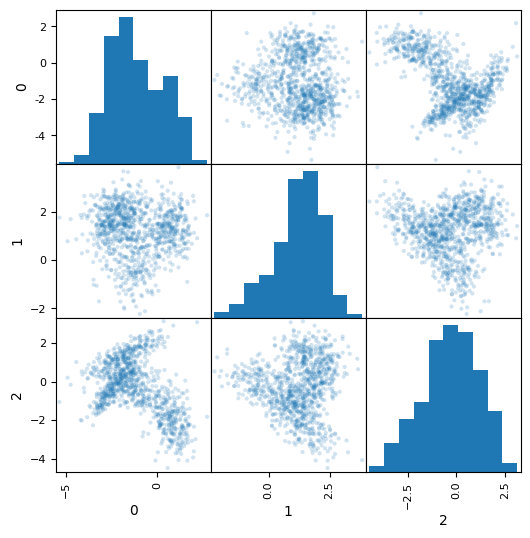

In [9]:
#create samples
np.random.seed([1])
samples, coeffs = sampleFromGauss(numDim=3, numGauss=4, muScale=5, covScale=1, numSamples=int(1e3))
#plot them for inspection
df = pd.DataFrame(samples)
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6))

# Calculate herding samples

In [10]:
def expKer(x,samples,gamma):
    #--calcuates the expectation value of the exponential kernel so argmax_x can be found
    #x = candidate super sample to optimize
    #samples = the GMM samples
    #gamma = kernel hyperparameter, always 1 for my demo
    
    #init vars
    numSamples = samples.shape[0]
    k=np.zeros(numSamples)
    #calculate estimate of expectation value of kernel
    for i in range(numSamples):
        k[i] = np.exp(-np.linalg.norm(x-samples[i,:])/gamma**2)
    exp_est = sum(k)/numSamples;
    return exp_est

def sumKer(x,xss,numSSsoFar,gamma):
    #--calcuates the sum of k(x,x_ss) for the number of super samps so far
    #x = candidate super sample to optimize
    #samples = the GMM samples
    #numSSsoFar = number of super sampls so far
    #gamma = kernel hyperparameter, always 1 for my demo
    
    #init vars
    total=0;
    k=np.zeros(numSSsoFar)
    #calculate sof of kernels
    for i in range(numSSsoFar):
        k[i] = np.exp(-np.linalg.norm(x-xss[i,:])/gamma**2)
    total = np.sum(k)
    s = total/(numSSsoFar+1)
    return s

In [ ]:
#-- main function

def herd(samples,totalSS,gamma):
    #-- calculate totalSS super samples from the distribution estimated by samples with kernel hyperparam gamma
    
    #init vars and extract useful info from inputs
    #get GMM dims and num samples
    numDim = samples.shape[1]
    numSamples = samples.shape[0]
    
    #init vars
    gradientFail = 0; #count when optimization fails, debugging
    xss = np.zeros((totalSS,numDim)) #open space in mem for array of super samples
    i=1
    #gradient descent can have some probems, so make bounds to terminate if goes too far away
    minBound = np.min(samples)
    maxBound = np.max(samples)
    #start our search at the origin, could be a random point
    bestSeed = np.zeros(numDim)
    
#     tick = time.clock()
    while i<totalSS:
        # print('.'),
        #debugging stuff
        #print "Working on SS num ber i=%d" % i
        #build function for gradient descent to find best point
        f = lambda x: -expKer(x,samples,gamma)+sumKer(x,xss,i,gamma)
        results = minimize(f,
                           bestSeed,
                           method='nelder-mead',
                           options={'xtol': 1e-4, 'disp': False})
#         print "results.x"
#         print results.x
        
        #if grad descent failed, pick a random sample and try again
        if np.min(results.x) < minBound or np.max(results.x) > maxBound:
            bestSeed=samples[np.random.choice(numSamples)]
            gradientFail=gradientFail+1
#             print "Gradient descent failed.............."
            continue
        
        #pick next best start point to start minimization, this is how Chen, Welling, Smola do it
        #find best super sample that maximizes argmax and use that as a seed for the next search
        #init or clear seed array
        seed=np.array([])
        for j in range(i):
            seed = np.append(seed,-expKer(xss[j,:],samples,gamma)+sumKer(xss[j,:],xss,i,gamma))
        bestSeedIdx = np.argmin(seed)
        bestSeed=xss[bestSeedIdx,:]
        
        #grad descent succeeded (yay!), so assign new value to super samples
        xss[i,:]=results.x
        
        i=i+1
        # toc = time.clock()
#         print "Time elapsed %d" % (toc-tick)
    return xss

In [15]:
totalSS=100
xss = herd(samples,totalSS,gamma=1)

.


/var/folders/5h/5g_dtdtn51s7j1n79mk1k9qw0000gn/T/ipykernel_73253/2778948046.py:28: OptimizeWarning: Unknown solver options: xtol
  results = minimize(f,


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


# Plot first 2 dims of distribution and super samples

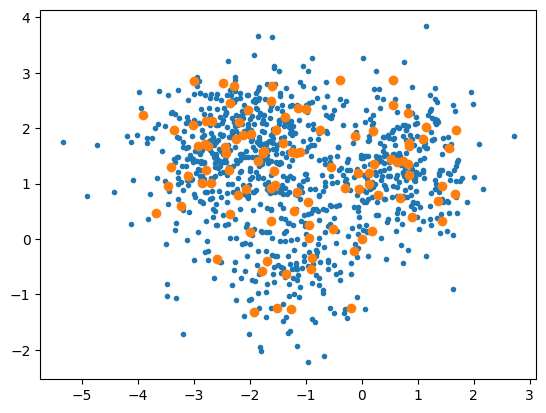

In [16]:
plt.plot(samples[:,0], samples[:,1], '.')
plt.plot(xss[:,0],xss[:,1],'o')

## Estimate error

Here I follow Chen, Welling, and Smola, and report the error as defined by equation 5:$err_N = norm(\mu_p - \frac{1}{N}\sum_i x_{ss,i})$. Essentially this compares the mean of the GMM to the mean estimated by super sampling. I compare this to the iid sampled mean.

In [17]:
# Calculate herding error
mu_p = np.mean(samples,axis=0)
err=np.zeros(totalSS)
for i in range(totalSS):
    err[i]    = np.linalg.norm(mu_p-np.sum(xss[1:i,:]        ,axis=0)/i)

idx = np.random.choice(1000,totalSS)
samples_iid=samples[idx,:]
err_iid=np.zeros(totalSS)
for i in range(totalSS):
    err_iid[i]= np.linalg.norm(mu_p-np.sum(samples_iid[1:i,:],axis=0)/i)

/var/folders/5h/5g_dtdtn51s7j1n79mk1k9qw0000gn/T/ipykernel_73253/1777227834.py:5: RuntimeWarning: invalid value encountered in divide
  err[i]    = np.linalg.norm(mu_p-np.sum(xss[1:i,:]        ,axis=0)/i)
/var/folders/5h/5g_dtdtn51s7j1n79mk1k9qw0000gn/T/ipykernel_73253/1777227834.py:11: RuntimeWarning: invalid value encountered in divide
  err_iid[i]= np.linalg.norm(mu_p-np.sum(samples_iid[1:i,:],axis=0)/i)


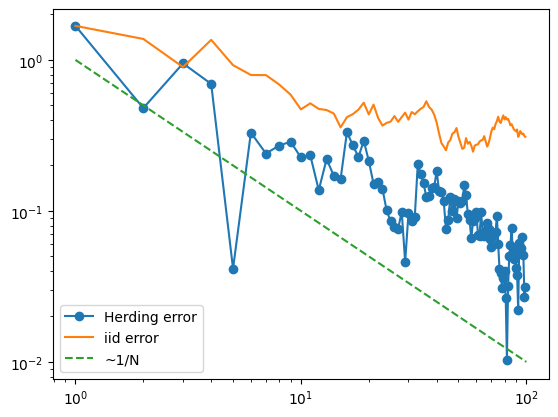

In [19]:
plt.plot(err,'-o')
plt.plot(err_iid)
plt.plot([1,totalSS],[1,1./totalSS],'--')
plt.yscale('log')
plt.xscale('log')
plt.legend(['Herding error','iid error','~1/N'], loc='lower left')